In [1]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import plotly.graph_objects as go

This project aims to train a Random Forest model using order book data from Bitcoin (top 10 bid and ask levels) across two days and predict short-term price movement (up, down, or unchanged) on the third day. The end application of this prediction is to develop a trading strategy based on these signals.

We decided to use a Random Forest model ...

In [2]:
#Read Data
csv_files1 = ['exchange1_20210519.csv', 'exchange1_20210520.csv']  

exchange_1 = pd.DataFrame()
for csv_file in csv_files1:
    df = pd.read_csv(csv_file, names=['MatchingTime', 'ReceivingTime', 'Symbol', 'BID_PRICE_1', 'BID_QTY_1', 'ASK_PRICE_1', 'ASK_QTY_1', 
 'BID_PRICE_2', 'BID_QTY_2', 'ASK_PRICE_2', 'ASK_QTY_2', 'BID_PRICE_3', 'BID_QTY_3', 'ASK_PRICE_3', 'ASK_QTY_3', 'BID_PRICE_4', 'BID_QTY_4', 'ASK_PRICE_4', 'ASK_QTY_4', 
 'BID_PRICE_5', 'BID_QTY_5', 'ASK_PRICE_5', 'ASK_QTY_5', 'BID_PRICE_6', 'BID_QTY_6', 'ASK_PRICE_6', 'ASK_QTY_6', 'BID_PRICE_7', 'BID_QTY_7', 'ASK_PRICE_7', 'ASK_QTY_7', 
 'BID_PRICE_8', 'BID_QTY_8', 'ASK_PRICE_8', 'ASK_QTY_8', 'BID_PRICE_9', 'BID_QTY_9', 'ASK_PRICE_9', 'ASK_QTY_9', 'BID_PRICE_10', 'BID_QTY_10', 'ASK_PRICE_10', 'ASK_QTY_10'])
    exchange_1 = pd.concat([exchange_1, df])

exchange_1 = exchange_1.drop_duplicates()

exchange_1_test =  pd.read_csv('exchange1_20210521.csv', names=['MatchingTime', 'ReceivingTime', 'Symbol', 'BID_PRICE_1', 'BID_QTY_1', 'ASK_PRICE_1', 'ASK_QTY_1', 
 'BID_PRICE_2', 'BID_QTY_2', 'ASK_PRICE_2', 'ASK_QTY_2', 'BID_PRICE_3', 'BID_QTY_3', 'ASK_PRICE_3', 'ASK_QTY_3', 'BID_PRICE_4', 'BID_QTY_4', 'ASK_PRICE_4', 'ASK_QTY_4', 
 'BID_PRICE_5', 'BID_QTY_5', 'ASK_PRICE_5', 'ASK_QTY_5', 'BID_PRICE_6', 'BID_QTY_6', 'ASK_PRICE_6', 'ASK_QTY_6', 'BID_PRICE_7', 'BID_QTY_7', 'ASK_PRICE_7', 'ASK_QTY_7', 
 'BID_PRICE_8', 'BID_QTY_8', 'ASK_PRICE_8', 'ASK_QTY_8', 'BID_PRICE_9', 'BID_QTY_9', 'ASK_PRICE_9', 'ASK_QTY_9', 'BID_PRICE_10', 'BID_QTY_10', 'ASK_PRICE_10', 'ASK_QTY_10'])

In [3]:
exchange_1.to_parquet('Train_data', index=False)
exchange_1_test.to_parquet('Test_data', index=False)

In [4]:
exchange_1.head()

,MatchingTime,ReceivingTime,Symbol,BID_PRICE_1,BID_QTY_1,ASK_PRICE_1,ASK_QTY_1,BID_PRICE_2,BID_QTY_2,ASK_PRICE_2,...,ASK_PRICE_8,ASK_QTY_8,BID_PRICE_9,BID_QTY_9,ASK_PRICE_9,ASK_QTY_9,BID_PRICE_10,BID_QTY_10,ASK_PRICE_10,ASK_QTY_10
0,2021-05-19T00:05:00.615Z,2021-05-19T00:05:00.642Z,BTC-PERP,42600.0,34.9140,42601.0,3.8347,42592.0,0.1174,42602.0,...,42615.0,3.9140,42581.0,0.0100,42616.0,1.2438,42580.0,3.7126,42617.0,1.7010
1,2021-05-19T00:05:00.641Z,2021-05-19T00:05:00.648Z,BTC-PERP,42600.0,35.2018,42601.0,3.8347,42592.0,0.1174,42602.0,...,42615.0,3.9140,42581.0,0.0100,42616.0,1.2438,42580.0,3.7126,42617.0,1.7010
2,2021-05-19T00:05:00.692Z,2021-05-19T00:05:00.703Z,BTC-PERP,42600.0,35.0053,42601.0,3.8347,42592.0,0.1174,42602.0,...,42615.0,3.9140,42581.0,0.0100,42616.0,1.2438,42580.0,3.7126,42617.0,1.7010
3,2021-05-19T00:05:00.742Z,2021-05-19T00:05:00.743Z,BTC-PERP,42600.0,35.0053,42601.0,3.8347,42592.0,0.1174,42602.0,...,42614.0,0.5608,42581.0,0.0100,42615.0,3.9140,42580.0,3.7126,42616.0,1.2438
4,2021-05-19T00:05:00.767Z,2021-05-19T00:05:00.773Z,BTC-PERP,42600.0,35.0053,42601.0,3.8347,42591.0,0.3754,42602.0,...,42617.0,1.7010,42580.0,3.5576,42618.0,2.7340,42579.0,0.8020,42619.0,3.3345


In [5]:
exchange_1.shape

(4523884, 43)

In [6]:
exchange_1_test.head()

,MatchingTime,ReceivingTime,Symbol,BID_PRICE_1,BID_QTY_1,ASK_PRICE_1,ASK_QTY_1,BID_PRICE_2,BID_QTY_2,ASK_PRICE_2,...,ASK_PRICE_8,ASK_QTY_8,BID_PRICE_9,BID_QTY_9,ASK_PRICE_9,ASK_QTY_9,BID_PRICE_10,BID_QTY_10,ASK_PRICE_10,ASK_QTY_10
0,2021-05-21T00:05:00.999Z,2021-05-21T00:05:01.006Z,BTC-PERP,40896.0,0.0354,40897.0,0.235,40894.0,0.021,40901.0,...,40916.0,0.5000,40871.0,0.3086,40917.0,0.0258,40869.0,1.5178,40918.0,0.0100
1,2021-05-21T00:05:01.014Z,2021-05-21T00:05:01.025Z,BTC-PERP,40896.0,0.0354,40897.0,0.235,40894.0,0.021,40901.0,...,40916.0,0.5000,40871.0,0.3086,40917.0,0.0258,40869.0,1.5178,40918.0,0.0100
2,2021-05-21T00:05:01.036Z,2021-05-21T00:05:01.051Z,BTC-PERP,40896.0,0.0354,40897.0,0.025,40894.0,0.021,40901.0,...,40916.0,0.5000,40869.0,1.5178,40917.0,0.0258,40868.0,0.0200,40918.0,0.0100
3,2021-05-21T00:05:01.088Z,2021-05-21T00:05:01.095Z,BTC-PERP,40896.0,0.4024,40897.0,0.025,40894.0,0.021,40901.0,...,40916.0,0.5000,40873.0,2.1058,40917.0,0.0258,40872.0,1.2059,40918.0,0.0100
4,2021-05-21T00:05:01.111Z,2021-05-21T00:05:01.118Z,BTC-PERP,40896.0,0.4024,40897.0,0.004,40894.0,0.021,40900.0,...,40915.0,0.0715,40875.0,0.0290,40916.0,0.5000,40873.0,2.1058,40917.0,0.0258


In [7]:
exchange_1_test.shape

(2403170, 43)

Order book data is extremely granular, with multiples updates per second. This raw data contains a lot of microstructure noise (rapid bid/ask fluctuations) that may not be meaniningful for predictive modelling. Resampling every 3 minutes, smooths this data by reducing the impact of irregular trade volumes or temporary price anomalies. 

Financial markets do not operate in strict intervals. However, machine learning algorithms perform best when the data has a consistent and interpretable time structure (each row represents a uniform time step and inputs are alligned temporarily with consistent spacing). Using fixed 3 minute intervals allows us to compute lagging features (rolling windows, differences) meaningfully. 

Set of features used:

+ Mid Price: Measures the central price between highes bid price and lowest ask price.

  Mid Price = (Bid + Ask) / 2

+ Spread: Indicates market liquidity and transaction cost; wide spreads suggest less efficiency.

  Spread = Bid - Ask

+ Order book imbalance: Relative difference between total bid and ask quantities (depth across top 10 levels), scaled to [-1, 1]. Captures order book imbalance; an indicator for demand/supply pressure.

  Imbalance = (Bid size- Ask_size) / (Bid size + Ask_size)

+ Mid price change: Detects recent short-term price movement or momentum.

  Mid price change =  MidPrice_t - MidPrice_{t-1}

+ Momentum_5: Price change over the last 5 intervals. Captures trend strength over a small window.
  Momentum_5 = MidPrice_t - MidPrice_{t-5}

+ Volatility_5: 	Rolling standard deviation of mid price over the last 5 intervals. Indicates uncertainty, useful for adjusting strategies in volatile markets. 

+ Rolling bid-ask difference: Rolling average of imbalance metric over 5 intervals. Smooths out noise in order book imbalance to focus on consistent trends.

+ Target signal: Computed from future return: +1 if > 0.001, -1 if < -0.001, else 0. Predictive target for the model indicating future price direction.
  
  Future return: Measure the expected change in price over a future time interval, in our case over the next 5 time intervals (which correspond to 5 × 3 minutes = 15 minutes, assuming 3-minute intervals).

  The reasoning behind this:
  
  - Direction Prediction: You want to predict whether the price will go up, down, or stay the same in the near future.

  - Return-Based Thresholding: By calculating the percentage return, you can create target classes for classification:

    * +1 if the future return > 0.1% → price expected to go up.

    * -1 if the return < -0.1% → price expected to go down.

    * 0 if return is between -0.1% and 0.1% → price is likely to stay stable.

  - Normalization: Expressing changes in terms of returns (rather than raw price differences) makes the model generalizable to different price levels or assets.

  Future return: (MidPrice_{t} - MidPrice_{t-5}) / MidPrice_{t}

In [8]:
#FUNCTIONS USED TO BUILD THE FEATURES USED TO PREDICT OUR SIGNAL ON DAY 3

def calculate_mid_price(df):
    #Calculate the mid price between the highest bid price and the lowest ask price
    df['MID_PRICE'] = (df['BID_PRICE_1']+df['ASK_PRICE_1'])/2

def calculate_spread(df):
    #Calculate the difference between the highest bid price and the lowest ask price
    df['SPREAD'] = (df['BID_PRICE_1']-df['ASK_PRICE_1'])

def bid_size_ask_size_difference_scaled(df):
    #Calculate the difference between the sum of all bid quantities and the sum of all ask quantities divided by the sum all all bid and ask quantities.
    #The reason is to restrict the values between -1 to 1.
    bid_size = df['BID_QTY_1'] + df['BID_QTY_2'] + df['BID_QTY_3'] + df['BID_QTY_4'] + df['BID_QTY_5'] + df['BID_QTY_6'] + df['BID_QTY_7'] + df['BID_QTY_8'] + df['BID_QTY_9'] + df['BID_QTY_10'] 
    ask_size = df['ASK_QTY_1'] + df['ASK_QTY_2'] + df['ASK_QTY_3'] + df['ASK_QTY_4'] + df['ASK_QTY_5'] + df['ASK_QTY_6'] + df['ASK_QTY_7'] + df['ASK_QTY_8'] + df['ASK_QTY_9'] + df['ASK_QTY_10']
    df['(BID_SIZE-ASK_SIZE)/(BID_SIZE+ASK_SIZE)'] = (bid_size-ask_size)/(bid_size+ask_size)

def change_to_datetime(df):
    #Convert from ISO 8601 to datetime
    df['MatchingTime'] = pd.to_datetime(df['MatchingTime'])
    df['ReceivingTime'] = pd.to_datetime(df['ReceivingTime'])

def get_means_3_minutes_interval(df):
    #Group the data in intervals of 3 minutes and compute the mean for all columns in each interval. 
    df = df.drop(columns=['ReceivingTime', 'Symbol'])
    df = df.resample('3min',on='MatchingTime').mean()
    return df

def get_mid_price_changes(df):
    #Compute the mid price change with respect to the previous value
    df['MID_PRICE_CHANGE'] = df['MID_PRICE'].diff()
     
def momentum_5(df):
    #Captures the price movement over the past 5 periods
    df['MOMENTUM_5'] = df['MID_PRICE'].diff(periods=5)

def rolling_mid_price(df):
    df['ROLLING_MID_PRICE_5'] = df['MID_PRICE'].rolling(window=5).mean()

def mid_price_vs_rolling(df):
    df['MID_PRICE_VS_ROLLING'] = df['MID_PRICE'] - df['ROLLING_MID_PRICE_5']

def rolling_mid_price_change(df):
    df['ROLLING_MID_PRICE_CHANGE_5'] = df['MID_PRICE_CHANGE'].rolling(window=5).mean()

def volatility_5(df):
    #Captures the standard deviation over the past 5 periods
    df['VOLATILITY_5'] = df['MID_PRICE'].rolling(window=5).std()

def rolling_bid_ask_diff(df):
    df ['ROLLING_BID_ASK_DIFF_5'] = df['(BID_SIZE-ASK_SIZE)/(BID_SIZE+ASK_SIZE)'].rolling(window=5).mean()

def rolling_spread(df):
    #Captures the  over the past 5 periods
    df['ROLLING_SPREAD_5'] = df['SPREAD'].rolling(window=5).mean()

##def obtained_signal(df):
    ##threshold = df['MID_PRICE_CHANGE'].std() *0.5
    ##df['OBTAINED_SIGNAL'] = np.where(df['MID_PRICE_CHANGE']> threshold, 1, np.where(df['MID_PRICE_CHANGE'] < -threshold, -1, 0))

def target_signal(df):
    df['FUTURE_RETURN'] = df['MID_PRICE'].shift(-5) / df['MID_PRICE'] - 1
    df['TARGET_SIGNAL'] = np.where(df['FUTURE_RETURN'] > 0.0032, 1, np.where(df['FUTURE_RETURN'] < -0.0032, -1, 0))
    #df['TARGET_SIGNAL'] = np.where(df['FUTURE_RETURN'] > 0.000001, 1, np.where(df['FUTURE_RETURN'] < -0.000001, -1, 0))

In [9]:
def search_optimum_depth(X_train, Y_train, X_test, Y_test):
    # Searching for the optimum tree depth
    depths = {}
    for depth in range(5, 30): 
        rf = RandomForestClassifier(max_depth=depth, criterion='gini', random_state=87)
        rf.fit(X_train, Y_train)
        score = rf.score(X_test, Y_test)
        depths[depth] = score
    
    temp = max(depths.values())
    optimum_depths = [key for key in depths if depths[key] == temp]
    return optimum_depths[0]

def search_optimum_estimators(X_train, Y_train, X_test, Y_test, optimum_depth):
    # Searching for the optimum number of estimators (trees)
    num_trees = {}
    for num in range(5, 200, 25):
        rf = RandomForestClassifier(max_depth=optimum_depth, criterion='gini', n_estimators=num, random_state=87)
        rf.fit(X_train, Y_train)
        score = rf.score(X_test, Y_test)
        num_trees[num] = score

    temp = max(num_trees.values())
    optimum_num_trees = [key for key in num_trees if num_trees[key] == temp]
    return optimum_num_trees[0]

def build_random_forest(df_train, df_test):
    # Feature list
    features = ['(BID_SIZE-ASK_SIZE)/(BID_SIZE+ASK_SIZE)', 
                'MID_PRICE_CHANGE', 
                'SPREAD', 
                'MOMENTUM_5', 
                'ROLLING_MID_PRICE_5',
                'MID_PRICE_VS_ROLLING', 
                'ROLLING_MID_PRICE_CHANGE_5',
                'VOLATILITY_5', 
                'ROLLING_BID_ASK_DIFF_5',
                'ROLLING_SPREAD_5']
    
    X_train = df_train[features]
    Y_train = df_train['TARGET_SIGNAL']
    X_test = df_test[features]
    Y_test = df_test['TARGET_SIGNAL']

    # Find best hyperparameters
    optimum_depth = search_optimum_depth(X_train, Y_train, X_test, Y_test)
    optimum_num_trees = search_optimum_estimators(X_train, Y_train, X_test, Y_test, optimum_depth)

    # Train Random Forest with best parameters
    rf = RandomForestClassifier(
        max_depth=optimum_depth,
        criterion='gini',
        n_estimators=optimum_num_trees,
        random_state=87, class_weight='balanced'
    )
    rf.fit(X_train, Y_train)
    Y_pred = rf.predict(X_test)

    # Collect Feature Importance
    feature_importance_df = pd.DataFrame({
        "Feature": features,
        "Importance": rf.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    # Collect Best Parameters
    best_params_df = pd.DataFrame({
        "Parameter": ["Optimum Depth", "Optimum Number of Trees"],
        "Value": [optimum_depth, optimum_num_trees]
    })

    return rf, Y_pred, feature_importance_df, best_params_df

In [10]:
#Data processing for training dataset 
change_to_datetime(exchange_1)
calculate_mid_price(exchange_1)
calculate_spread(exchange_1)
bid_size_ask_size_difference_scaled(exchange_1)
exchange_1 = get_means_3_minutes_interval(exchange_1)
get_mid_price_changes(exchange_1)
momentum_5(exchange_1)
rolling_mid_price(exchange_1)
mid_price_vs_rolling(exchange_1)
rolling_mid_price_change(exchange_1)
volatility_5(exchange_1)
rolling_bid_ask_diff(exchange_1)
rolling_spread(exchange_1)
target_signal(exchange_1)

exchange_1.head()

,BID_PRICE_1,BID_QTY_1,ASK_PRICE_1,ASK_QTY_1,BID_PRICE_2,BID_QTY_2,ASK_PRICE_2,ASK_QTY_2,BID_PRICE_3,BID_QTY_3,...,MID_PRICE_CHANGE,MOMENTUM_5,ROLLING_MID_PRICE_5,MID_PRICE_VS_ROLLING,ROLLING_MID_PRICE_CHANGE_5,VOLATILITY_5,ROLLING_BID_ASK_DIFF_5,ROLLING_SPREAD_5,FUTURE_RETURN,TARGET_SIGNAL
MatchingTime,,,,,,,,,,,,,,,,,,,,,
2021-05-19 00:03:00+00:00,42649.907397,3.287158,42652.337098,2.632772,42647.638058,1.741530,42654.955957,1.889840,42645.800113,2.498002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014714,1
2021-05-19 00:06:00+00:00,43267.300606,2.368565,43270.597426,1.144667,43264.687532,1.469502,43273.272085,1.011621,43262.627966,1.766334,...,617.826768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000383,0
2021-05-19 00:09:00+00:00,43473.024390,2.388351,43475.460488,1.984703,43470.494634,1.531416,43477.725659,1.343118,43468.552976,1.665008,...,205.293423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004504,-1
2021-05-19 00:12:00+00:00,43509.315667,2.907989,43511.629400,1.765715,43506.900580,1.539436,43514.041779,1.210159,43505.026499,1.381991,...,36.230095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005756,-1
2021-05-19 00:15:00+00:00,43423.713223,2.055507,43425.940279,2.765232,43421.518222,1.044530,43428.427018,2.601833,43419.638237,1.264341,...,-85.645783,NaN,43265.922597,158.904153,NaN,355.823337,0.031691,-2.540681,-0.005581,-1


In [11]:
exchange_1.shape

(961, 53)

In [12]:
exchange_1['TARGET_SIGNAL'].value_counts()

TARGET_SIGNAL
-1    382
 1    325
 0    254
Name: count, dtype: int64

In [13]:
#Data processing for test dataset
change_to_datetime(exchange_1_test)
calculate_mid_price(exchange_1_test)
calculate_spread(exchange_1_test)
bid_size_ask_size_difference_scaled(exchange_1_test)
exchange_1_test = get_means_3_minutes_interval(exchange_1_test)
get_mid_price_changes(exchange_1_test)
momentum_5(exchange_1_test)
rolling_mid_price(exchange_1_test)
mid_price_vs_rolling(exchange_1_test)
rolling_mid_price_change(exchange_1_test)
volatility_5(exchange_1_test)
rolling_bid_ask_diff(exchange_1_test)
rolling_spread(exchange_1_test)
target_signal(exchange_1_test)

exchange_1_test.head()

,BID_PRICE_1,BID_QTY_1,ASK_PRICE_1,ASK_QTY_1,BID_PRICE_2,BID_QTY_2,ASK_PRICE_2,ASK_QTY_2,BID_PRICE_3,BID_QTY_3,...,MID_PRICE_CHANGE,MOMENTUM_5,ROLLING_MID_PRICE_5,MID_PRICE_VS_ROLLING,ROLLING_MID_PRICE_CHANGE_5,VOLATILITY_5,ROLLING_BID_ASK_DIFF_5,ROLLING_SPREAD_5,FUTURE_RETURN,TARGET_SIGNAL
MatchingTime,,,,,,,,,,,,,,,,,,,,,
2021-05-21 00:03:00+00:00,40791.076374,0.432533,40794.458244,0.595494,40787.890792,0.276335,40798.014276,0.412606,40785.245539,0.354413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005709,1
2021-05-21 00:06:00+00:00,40784.007831,0.432098,40787.152506,0.357602,40780.987862,0.394010,40790.408379,0.361197,40778.733751,0.440828,...,-7.187141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003452,1
2021-05-21 00:09:00+00:00,40886.444304,0.301375,40889.413502,0.523231,40883.494515,0.310047,40892.659494,0.432678,40881.410970,0.318958,...,102.348735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003447,1
2021-05-21 00:12:00+00:00,41015.746516,0.347085,41019.173635,0.526417,41013.102260,0.403224,41022.512053,0.361539,41010.975895,0.416691,...,129.531172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003450,1
2021-05-21 00:15:00+00:00,40935.917267,0.399623,40938.520343,1.233628,40932.896243,0.382393,40941.470897,0.595841,40930.671014,0.463567,...,-80.241271,NaN,40884.191052,53.027753,NaN,98.322116,0.078216,-3.105188,0.009333,1


In [14]:
exchange_1_test.shape

(481, 53)

In [15]:
exchange_1.dropna(inplace=True)
exchange_1_test.dropna(inplace=True)

In [16]:
#Run Random Forest
rf_model, Y_pred, feature_importance_df, best_params_df = build_random_forest(exchange_1, exchange_1_test)
print(classification_report(exchange_1_test['TARGET_SIGNAL'], Y_pred))

# Display Tables
print(best_params_df)
print(feature_importance_df)

# Display Graph
fig = go.Figure()
fig.add_trace(go.Bar(
    x=feature_importance_df['Importance'],
    y=feature_importance_df['Feature'],
    orientation='h',
    marker=dict(color='skyblue')
))
fig.update_layout(
    title="Feature Importance from Random Forest",
    xaxis_title="Importance",
    yaxis_title="Feature",
    template='plotly_white'
)
fig.show()

              precision    recall  f1-score   support

          -1       0.39      0.49      0.43       170
           0       0.36      0.26      0.30       145
           1       0.42      0.41      0.41       156

    accuracy                           0.39       471
   macro avg       0.39      0.39      0.38       471
weighted avg       0.39      0.39      0.39       471

                 Parameter  Value
0            Optimum Depth     25
1  Optimum Number of Trees      5
                                   Feature  Importance
4                      ROLLING_MID_PRICE_5    0.142345
9                         ROLLING_SPREAD_5    0.127795
8                   ROLLING_BID_ASK_DIFF_5    0.112721
7                             VOLATILITY_5    0.112232
0  (BID_SIZE-ASK_SIZE)/(BID_SIZE+ASK_SIZE)    0.089739
5                     MID_PRICE_VS_ROLLING    0.089585
2                                   SPREAD    0.086202
3                               MOMENTUM_5    0.080256
6               ROLLIN

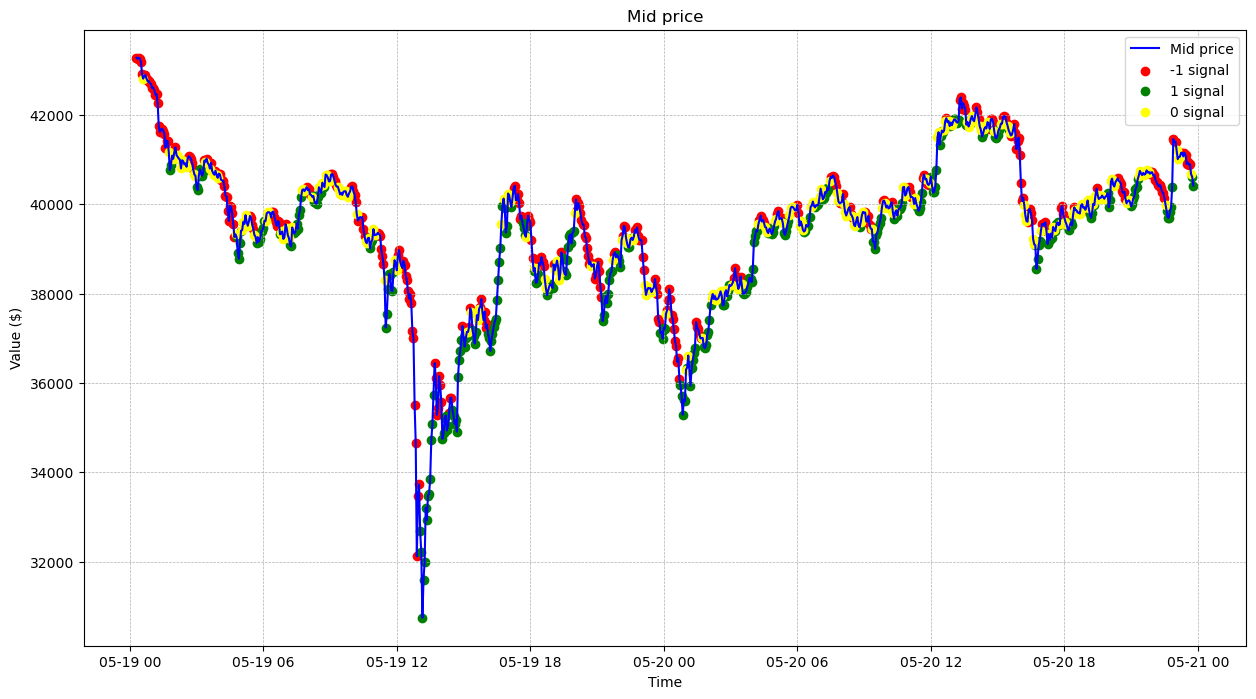

In [17]:
red_markers=exchange_1['MID_PRICE'][exchange_1['TARGET_SIGNAL']==-1]
y_red = exchange_1.index[exchange_1['TARGET_SIGNAL']==-1]
green_markers = exchange_1['MID_PRICE'][exchange_1['TARGET_SIGNAL']==1]
y_green = exchange_1.index[exchange_1['TARGET_SIGNAL']==1]
yellow_markers = exchange_1['MID_PRICE'][exchange_1['TARGET_SIGNAL']==0]
y_yellow = exchange_1.index[exchange_1['TARGET_SIGNAL']==0]

plt.figure(figsize=(15,8))
plt.plot(exchange_1['MID_PRICE'], 'b', label='Mid price')
plt.scatter(y_red, red_markers, c='red', label='-1 signal')
plt.scatter(y_green, green_markers, c='green', label='1 signal')
plt.scatter(y_yellow, yellow_markers, c='yellow', label='0 signal')
plt.title('Mid price')
plt.xlabel('Time')
plt.ylabel('Value ($)')
plt.legend()
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()


In [18]:
# Create the figure
fig = go.Figure()

# Plot Mid Price Line
fig.add_trace(go.Scatter(
    x=exchange_1.index,
    y=exchange_1['MID_PRICE'],
    mode='lines',
    name='Mid price',
    line=dict(color='blue')
))

# Scatter Red markers (-1 signal)
fig.add_trace(go.Scatter(
    x=exchange_1.index[exchange_1['TARGET_SIGNAL'] == -1],
    y=exchange_1['MID_PRICE'][exchange_1['TARGET_SIGNAL'] == -1],
    mode='markers',
    name='-1 signal',
    marker=dict(color='red', size=8, symbol='x')
))

# Scatter Green markers (+1 signal)
fig.add_trace(go.Scatter(
    x=exchange_1.index[exchange_1['TARGET_SIGNAL'] == 1],
    y=exchange_1['MID_PRICE'][exchange_1['TARGET_SIGNAL'] == 1],
    mode='markers',
    name='1 signal',
    marker=dict(color='green', size=8, symbol='triangle-up')
))

# Scatter Yellow markers (0 signal)
fig.add_trace(go.Scatter(
    x=exchange_1.index[exchange_1['TARGET_SIGNAL'] == 0],
    y=exchange_1['MID_PRICE'][exchange_1['TARGET_SIGNAL'] == 0],
    mode='markers',
    name='0 signal',
    marker=dict(color='yellow', size=8, symbol='circle')
))

# Update layout (title, labels, grid)
fig.update_layout(
    title='Mid Price with Signals',
    xaxis_title='Time',
    yaxis_title='Value ($)',
    legend=dict(x=0, y=1),
    hovermode='x unified',
    template='plotly_white'
)

# Show the interactive plot
fig.show()

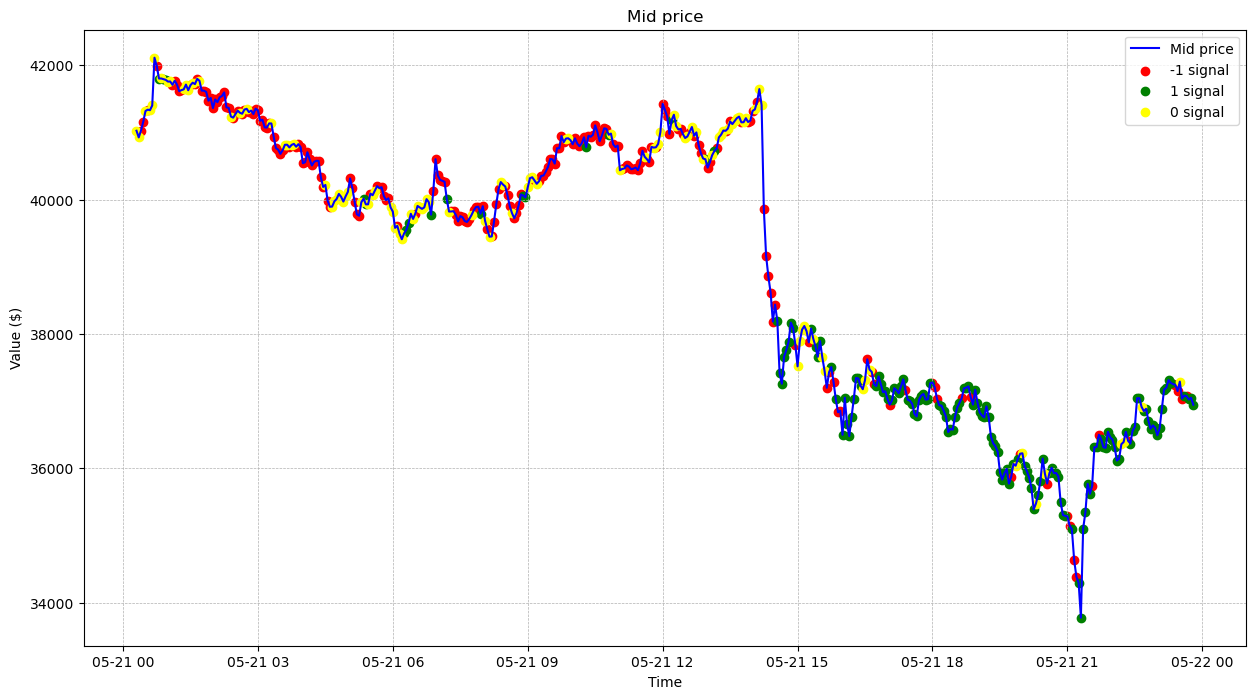

In [19]:
exchange_1_test['Y_pred']= Y_pred
exchange_1_test
red_markers_test=exchange_1_test['MID_PRICE'][exchange_1_test['Y_pred']==-1]
y_red_test = exchange_1_test.index[exchange_1_test['Y_pred']==-1]
green_markers_test = exchange_1_test['MID_PRICE'][exchange_1_test['Y_pred']==1]
y_green_test = exchange_1_test.index[exchange_1_test['Y_pred']==1]
yellow_markers_test= exchange_1_test['MID_PRICE'][exchange_1_test['Y_pred']==0]
y_yellow_test= exchange_1_test.index[exchange_1_test['Y_pred']==0]

plt.figure(figsize=(15,8))
plt.plot(exchange_1_test['MID_PRICE'], 'b', label='Mid price')
plt.scatter(y_red_test, red_markers_test, c='red', label='-1 signal')
plt.scatter(y_green_test, green_markers_test, c='green', label='1 signal')
plt.scatter(y_yellow_test, yellow_markers_test, c='yellow', label='0 signal')
plt.title('Mid price')
plt.xlabel('Time')
plt.ylabel('Value ($)')
plt.legend()
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

In [20]:
# Add the Y_pred column 
exchange_1_test['Y_pred'] = Y_pred

# Create the figure
fig = go.Figure()

# Plot Mid Price Line
fig.add_trace(go.Scatter(
    x=exchange_1_test.index,
    y=exchange_1_test['MID_PRICE'],
    mode='lines',
    name='Mid price',
    line=dict(color='blue')
))

# Scatter Red markers (-1 predicted signal)
fig.add_trace(go.Scatter(
    x=exchange_1_test.index[exchange_1_test['Y_pred'] == -1],
    y=exchange_1_test['MID_PRICE'][exchange_1_test['Y_pred'] == -1],
    mode='markers',
    name='Predicted -1 signal',
    marker=dict(color='red', size=8, symbol='x')
))

# Scatter Green markers (+1 predicted signal)
fig.add_trace(go.Scatter(
    x=exchange_1_test.index[exchange_1_test['Y_pred'] == 1],
    y=exchange_1_test['MID_PRICE'][exchange_1_test['Y_pred'] == 1],
    mode='markers',
    name='Predicted 1 signal',
    marker=dict(color='green', size=8, symbol='triangle-up')
))

# Scatter Yellow markers (0 predicted signal)
fig.add_trace(go.Scatter(
    x=exchange_1_test.index[exchange_1_test['Y_pred'] == 0],
    y=exchange_1_test['MID_PRICE'][exchange_1_test['Y_pred'] == 0],
    mode='markers',
    name='Predicted 0 signal',
    marker=dict(color='yellow', size=8, symbol='circle')
))

# Update layout (title, labels, grid)
fig.update_layout(
    title='Mid Price with Predicted Signals',
    xaxis_title='Time',
    yaxis_title='Value ($)',
    legend=dict(x=0, y=1),
    hovermode='x unified',
    template='plotly_white'
)

# Show the interactive plot
fig.show()


In [21]:
# Parameters 
SPREAD_THRESHOLD = 0.001
CONFIDENCE_THRESHOLD = 0.6  
EXPECTED_MOVE_THRESHOLD = 0.001  
STOP_LOSS_PERCENTAGE = 0.002  # 0.2%
LIQUIDATION_HOLD_TIME = 5  # After 5 steps without exit, force liquidation
LATENCY = 0.1

FEATURE_NAMES = ['(BID_SIZE-ASK_SIZE)/(BID_SIZE+ASK_SIZE)', 'MID_PRICE_CHANGE', 'SPREAD', 'MOMENTUM_5', 'ROLLING_MID_PRICE_5', 'MID_PRICE_VS_ROLLING', 
                'ROLLING_MID_PRICE_CHANGE_5', 'VOLATILITY_5', 'ROLLING_BID_ASK_DIFF_5', 'ROLLING_SPREAD_5']


def simulate_trading(df, model, strategy_number, position_size=100000, fee=0.0001):
    cash = position_size
    inventory = 0
    cumulative_profit = []
    hold_time = 0
    entry_price = None  # Track entry price for stop-loss
    trade_log = []

    for i in range(1, len(df)):
        row = df.iloc[i]
        spread = row['SPREAD']

        # Dynamic fill probability based on spread
        fill_probability = max(0.1, 1 - (spread / SPREAD_THRESHOLD))
        order_filled = np.random.rand() < fill_probability

        # Model prediction
        features = pd.DataFrame([row[FEATURE_NAMES].values], columns=FEATURE_NAMES)
        pred_proba = model.predict_proba(features)[0]
        pred_class = model.predict(features)[0]
        confidence = np.max(pred_proba)

        action = None
        mid_price = row['MID_PRICE']
        trade_size = 1 + int((confidence - CONFIDENCE_THRESHOLD) * 10)

        # Add minimum expected profit threshold
        expected_return = confidence * (1 if pred_class == 1 else -1)
        min_required_return = fee + (spread / mid_price)
        if abs(expected_return) < min_required_return:
            continue  # skip low edge trades

        if pred_class != 0 and confidence >= CONFIDENCE_THRESHOLD and order_filled:

            # Strategy 0: Directional based on signal 
            if strategy_number == 0:
                if pred_class == 1:
                    cash -= mid_price * (1 + fee) * trade_size
                    inventory += trade_size
                    entry_price = mid_price
                    action = 'BUY'
                elif pred_class == -1 and inventory > 0:
                    cash += mid_price * (1 - fee) * inventory
                    inventory = 0
                    entry_price = None
                    action = 'SELL'

            # Strategy 1: Long-only if volatility is low 
            elif strategy_number == 1:
                if pred_class == 1 and row['VOLATILITY_5'] < 0.02:
                    cash -= mid_price * (1 + fee) * trade_size
                    inventory += trade_size
                    entry_price = mid_price
                    action = 'BUY (LOW VOL)'

            #  Strategy 2: Quick scalp on confident signals 
            elif strategy_number == 2:
                if pred_class == 1 and confidence >= 0.8:
                    cash -= mid_price * (1 + fee) * trade_size
                    inventory += trade_size
                    entry_price = mid_price
                    action = 'BUY (SCALP)'
                elif pred_class == -1 and inventory > 0 and confidence >= 0.8:
                    cash += mid_price * (1 - fee) * inventory
                    inventory = 0
                    entry_price = None
                    action = 'SELL (SCALP)'

        # Stop-loss
        if entry_price and inventory > 0 and row['MID_PRICE'] < entry_price * (1 - STOP_LOSS_PERCENTAGE):
            cash += row['MID_PRICE'] * (1 - fee) * inventory
            action = 'STOP-LOSS'
            inventory = 0
            entry_price = None

        # Liquidate after holding period
        if inventory != 0:
            hold_time += 1
            if hold_time >= LIQUIDATION_HOLD_TIME:
                cash += row['MID_PRICE'] * (1 - fee) * inventory
                inventory = 0
                entry_price = None
                hold_time = 0
                action = 'LIQUIDATE'

        portfolio_value = cash + inventory * row['MID_PRICE']
        cumulative_profit.append(portfolio_value)

        if action:
            trade_log.append({
                'index': i,
                'price': row['MID_PRICE'],
                'action': action,
                'confidence': confidence,
                'pred_class': pred_class,
                'spread': spread,
                'inventory': inventory,
                'portfolio_value': portfolio_value
            })

    final_price = df.iloc[-1]['MID_PRICE']
    cash += inventory * final_price * (1 - fee)

    return {
        'Final Cash': cash,
        'Cumulative Profit': cumulative_profit,
        'Trade Log': trade_log
    }

In [22]:
results_strategy0 = simulate_trading(exchange_1_test, rf_model, strategy_number=0)
results_strategy0

{'Final Cash': 101370.59200971568,
 'Cumulative Profit': [100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  99995.81975901927,
  99997.18563377325,
  99981.95055808415,
  99958.5985703801,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.27468204939,
  99869.2746820493

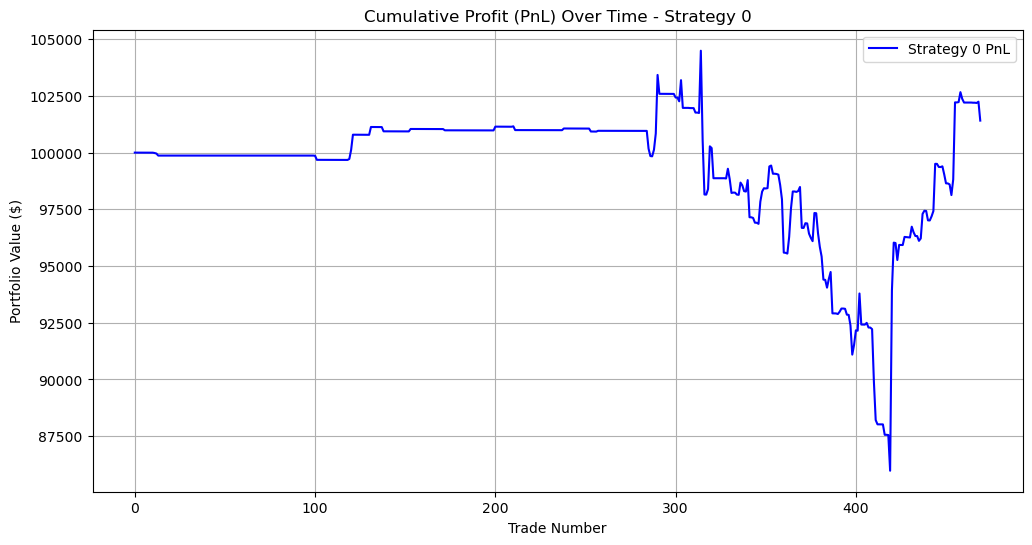

In [23]:
# Plotting Cumulative Profit (PnL)
plt.figure(figsize=(12,6))
plt.plot(results_strategy0['Cumulative Profit'], label='Strategy 0 PnL', color='blue')
plt.title('Cumulative Profit (PnL) Over Time - Strategy 0')
plt.xlabel('Trade Number')
plt.ylabel('Portfolio Value ($)')
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.grid(True)
plt.show()


In [24]:
results_strategy1 = simulate_trading(exchange_1_test, rf_model, strategy_number=1)
results_strategy1

{'Final Cash': 100000.0,
 'Cumulative Profit': [100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  1000

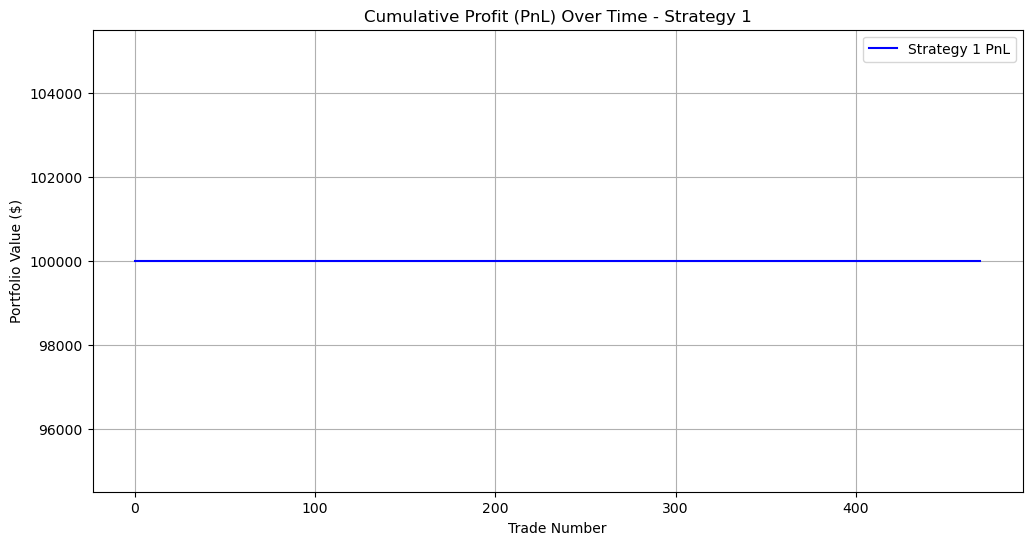

In [25]:
# Plotting Cumulative Profit (PnL)
plt.figure(figsize=(12,6))
plt.plot(results_strategy1['Cumulative Profit'], label='Strategy 1 PnL', color='blue')
plt.title('Cumulative Profit (PnL) Over Time - Strategy 1')
plt.xlabel('Trade Number')
plt.ylabel('Portfolio Value ($)')
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.grid(True)
plt.show()


In [26]:
results_strategy2 = simulate_trading(exchange_1_test, rf_model, strategy_number=2)
results_strategy2

{'Final Cash': 113789.47856489843,
 'Cumulative Profit': [100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000.0,
  100000

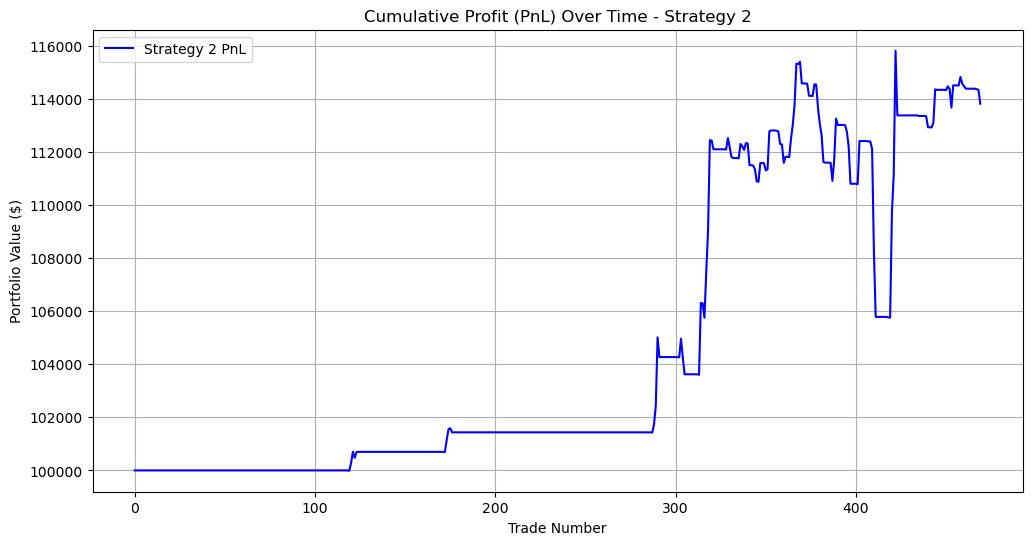

In [27]:
# Plotting Cumulative Profit (PnL)
plt.figure(figsize=(12,6))
plt.plot(results_strategy2['Cumulative Profit'], label='Strategy 2 PnL', color='blue')
plt.title('Cumulative Profit (PnL) Over Time - Strategy 2')
plt.xlabel('Trade Number')
plt.ylabel('Portfolio Value ($)')
plt.ticklabel_format(useOffset=False)
plt.legend()
plt.grid(True)
plt.show()